<a href="https://colab.research.google.com/github/blueeagle100/3d_bounding_boxes/blob/main/3d_box_lidar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3D Bounding Boxes from LiDAR Point Cloud Data**

In this tutorial we will learn how to draw 3D bounding boxes on detected objects. The high level pipeline will be:
- In the camera images, detect objects in 2D 
- Project LiDAR Depth information on the object 
- Get 3D location of object in image/camera space
- Draw 3D bounding box


Once again, the KITTI dataset is located [here]()http://www.cvlibs.net/datasets/kitti/raw_data.php a readme for the KITTI data can be found [here](https://github.com/yanii/kitti-pcl/blob/master/KITTI_README.TXT). A paper that details the data collection can be found [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf)



### **Download the Data**
Let's donwload the data, I am using the raw city data (2011_09_26_drive_0106_sync).

This data is synced and rectified, which is very important for this excercise

In [1]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip

--2022-08-31 11:32:21--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0106/2011_09_26_drive_0106_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.170.209
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.170.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 936875950 (893M) [application/zip]
Saving to: ‘2011_09_26_drive_0106_sync.zip’

2011_09_26_drive_01 100%[===================>] 893.47M  31.8MB/s    in 29s     

2022-08-31 11:32:51 (30.5 MB/s) - ‘2011_09_26_drive_0106_sync.zip’ saved [936875950/936875950]



And now we will download the corresponding calibration file which contains several transformation matrices that we will need

In [2]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip

--2022-08-31 11:32:51--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.170.177
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.170.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4068 (4.0K) [application/zip]
Saving to: ‘2011_09_26_calib.zip’

2011_09_26_calib.zi 100%[===================>]   3.97K  --.-KB/s    in 0s      

2022-08-31 11:32:51 (151 MB/s) - ‘2011_09_26_calib.zip’ saved [4068/4068]



In [1]:
!jar xf 2011_09_26_drive_0106_sync.zip

In [2]:
!jar xf 2011_09_26_calib.zip

In our data folder we have images from 2 gray stereo cameras and 2 color stereo cameras. We also have LiDAR point clouds and GPS and IMU data. The LiDAR used in the KITTI dataset is a Velodyne LiDAR, so the variables that refer to 'velo' actually refer to the LiDAR point cloud.

Just as in part1, we will use data from the 2 color cameras. The folder labeled "image_02" corresponds to the left camera and "image_03" corresponds to the right camera.

#### Base Library Import

In [3]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

### **Get data**

In [4]:
DATA_PATH = r'2011_09_26/2011_09_26_drive_0106_sync'

left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")

Number of left images: 227
Number of right images: 227
Number of LiDAR point clouds: 227


### **Get Camera Calibration Data**

Here we will get calibration data for both color cameras, and we will get the rotation and trnaslation matrix for LiDAR to camera frame of reference.


In [5]:
with open('2011_09_26/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices
P_left = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in calib[33].strip().split(' ')[1:]]).reshape((3,4))

# get rectified rotation matrices
R_left_rect = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_right_rect = np.array([float(x) for x in calib[32].strip().split(' ')[1:]]).reshape((3, 3,))

R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0], axis=0)
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0,1], axis=1)

In [6]:
def decompose_projection_matrix(P):    
    K, R, T, _, _, _, _ = cv2.decomposeProjectionMatrix(P)
    T = T/T[3]

    return K, R, T

In [7]:
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)

Once again: the projection matrices will be decomposed into:
 - The Intrinsic Calibration Matrix (K) 
 - The rotation Matrix (R)
 - The translation Matrix (T)

The rectified Rotation matrices will be used to help transform a LiDAR point to the camera frame of reference.

#### **Get LiDAR to Camera Rotation and Translation Matrices**

In [8]:
with open(r'2011_09_26/calib_velo_to_cam.txt', 'r') as f:
    calib = f.readlines()

R_cam_velo = np.array([float(x) for x in calib[1].strip().split(' ')[1:]]).reshape((3, 3))
t_cam_velo = np.array([float(x) for x in calib[2].strip().split(' ')[1:]])[:, None]

T_cam_velo = np.vstack((np.hstack((R_cam_velo, t_cam_velo)),
                        np.array([0, 0, 0, 1])))

T_cam_velo

array([[ 7.533745e-03, -9.999714e-01, -6.166020e-04, -4.069766e-03],
       [ 1.480249e-02,  7.280733e-04, -9.998902e-01, -7.631618e-02],
       [ 9.998621e-01,  7.523790e-03,  1.480755e-02, -2.717806e-01],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]])

The LiDAR to Camer translation matrix will allow us to rotate any 3D LiDAR point to the camera pixel space

$$ y = P^{(i)}_{rect} R^{(0)}_{rect} T^{cam}_{velo} x,
  \qquad \text{where } x = [x, y, z, 1]^T $$
NOTE:  x is the 3D point in homogeneous coordinates.

Since we will be using the left image we will go ahead and make a function to rotate a single LiDAR poin to the left image.

In [152]:
# matrix to transform from velo (LiDAR) to left color camera
T_velo_cam = P_left @ R_left_rect @ T_cam_velo
T_velo_cam

array([[     613.04,     -718.58,       -2.95,     -124.07],
       [     182.76,       12.24,     -718.99,     -101.61],
       [    0.99989,   0.0046974,    0.013829,    -0.26912]])

### **Create LiDAR points pipeline**

We will read in the LiDAR point clouds and transform them to the image plane. The code is partially based on the this [repository](https://github.com/azureology/kitti-velo2cam). Once again the information for the calibration parameters is located [here](http://www.cvlibs.net/publications/Geiger2013IJRR.pdf)

In [153]:
def velo2camera(velo_points, image=None, remove_outliers=True):
    ''' maps velo points (LiDAR) to camera (u,v,z) space '''
    # convert to (left) camera coordinates
    # P_left @ R_left_rect @ T_cam_velo
    velo_camera =  T_velo_cam @ velo_points

    # delete negative camera points ??
    velo_camera  = np.delete(velo_camera , np.where(velo_camera [2,:] < 0)[0], axis=1) 

    # get camera coordinates u,v,z
    velo_camera[:2] /= velo_camera[2, :]

    # remove outliers (points outside of the image frame)
    if remove_outliers:
        u, v, z = velo_camera
        img_h, img_w, _ = image.shape
        u_out = np.logical_or(u < 0, u > img_w)
        v_out = np.logical_or(v < 0, v > img_h)
        outlier = np.logical_or(u_out, v_out)
        velo_camera = np.delete(velo_camera, np.where(outlier), axis=1)

    return velo_camera

In [154]:
from sklearn import linear_model

def bin2h_velo(lidar_bin, remove_plane=True):
    ''' Reads LiDAR bin file and returns homogeneous (x,y,z,1) LiDAR points'''
    # read in LiDAR data
    scan_data = np.fromfile(lidar_bin, dtype=np.float32).reshape((-1,4))

    # get x,y,z LiDAR points (x, y, z) --> (front, left, up)
    velo_points = scan_data[:, 0:3] 

    # delete negative liDAR points
    velo_points = np.delete(velo_points, np.where(velo_points[3, :] < 0), axis=1)

    # use ransac to remove ground plane
    if remove_plane:
            ransac = linear_model.RANSACRegressor(
                                          linear_model.LinearRegression(),
                                          residual_threshold=0.1,
                                          max_trials=5000
                                          )

            X = velo_points[:, :2]
            y = velo_points[:, -1]
            ransac.fit(X, y)


            # remove outlier points
            mask = ransac.inlier_mask_
            velo_points = velo_points[~mask]

    # homogeneous LiDAR points
    velo_points = np.insert(velo_points, 3, 1, axis=1).T 

    return velo_points

In [155]:
def project_velo2cam(lidar_bin, image, remove_plane=True):
    ''' Projects LiDAR point cloud onto the image coordinate frame '''

    # get homogeneous LiDAR points from binn file
    velo_points = bin2h_velo(lidar_bin, remove_plane)

    # get camera (u, v, z) coordinates
    velo_camera = velo2camera(velo_points, image, remove_outliers=True)
    
    return velo_camera

In [156]:
index = 120

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
lidar_bin = bin_paths[index]

(u, v, z) = project_velo2cam(lidar_bin, left_image)

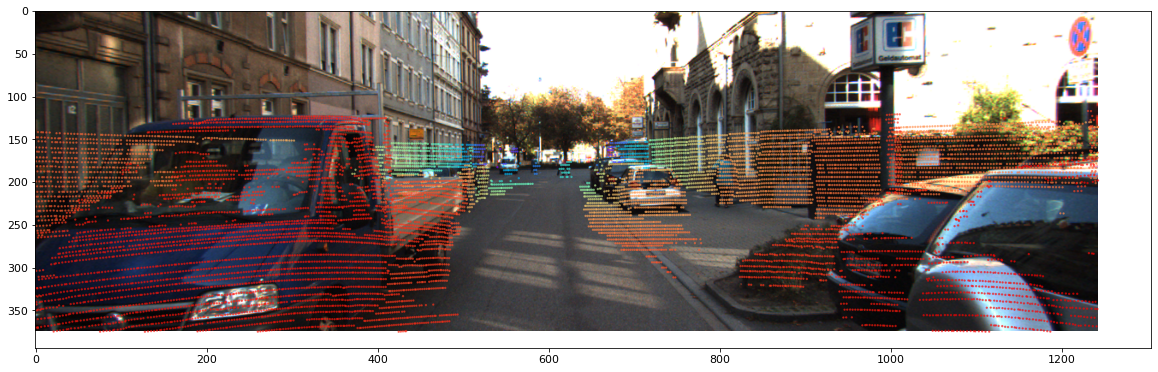

In [157]:
# plot points over iamge
plt.imshow(left_image)
plt.scatter([u], [v], c=[z], cmap='rainbow_r', alpha=0.5, s=2);

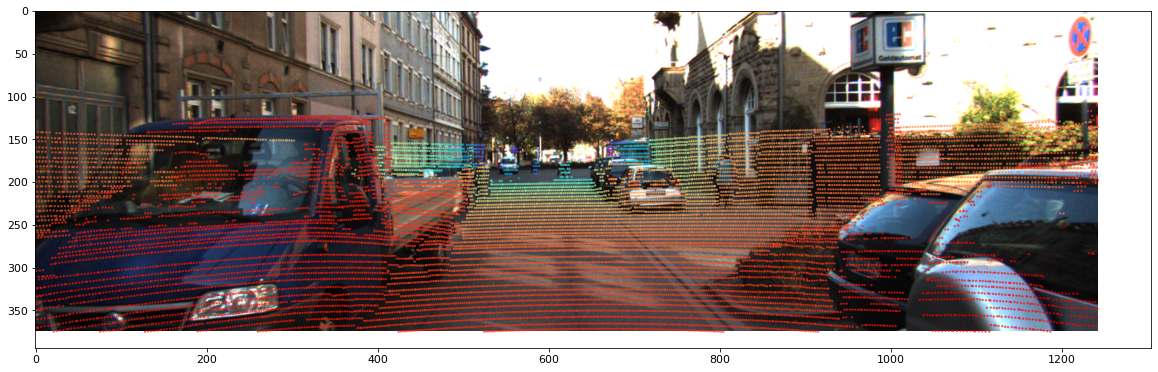

In [158]:
(u, v, z) = project_velo2cam(lidar_bin, left_image, remove_plane=False)

# plot points over iamge
plt.imshow(left_image)
plt.scatter([u], [v], c=[z], cmap='rainbow_r', alpha=0.5, s=2);

## **Get Object Detection Pipeline**

Just like part 1, we will use yolov5

In [15]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 12122, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 12122 (delta 39), reused 53 (delta 27), pack-reused 12047
Receiving objects: 100% (12122/12122), 12.59 MiB | 16.65 MiB/s, done.
Resolving deltas: 100% (8332/8332), done.


In [ ]:
!pip install -r yolov5/requirements.txt  #Install whatever is needed

In [20]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # or yolov5m, yolov5l, yolov5x, custom

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-8-31 Python-3.7.13 torch-1.12.1+cu113 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [21]:
# set confidence and IOU thresholds
model.conf = 0.25  # confidence threshold (0-1), default: 0.25
model.iou = 0.25  # NMS IoU threshold (0-1), default: 0.45

In [159]:
def get_distances(image, velo_camera, bboxes, draw=True):
    ''' Obtains distance measurements for each detected object in the image 
        Inputs:
          image - input image for detection 
          bboxes - xyxy bounding boxes form detections from yolov5 model output
          method - distance metric (median or center)
        Outputs:
          image - input image with distances drawn at the center of each 
                  bounding box
        '''

    # unpack LiDAR camera coordinates
    u, v, z = velo_camera

    # get new output
    bboxes_out = np.zeros((bboxes.shape[0], bboxes.shape[1] + 3))
    bboxes_out[:, :bboxes.shape[1]] = bboxes

    for i, bbox in enumerate(bboxes):
        pt1 = torch.round(bbox[0:2]).to(torch.int).numpy()
        pt2 = torch.round(bbox[2:4]).to(torch.int).numpy()

        # get center location of the image
        x_center = (pt1[1] + pt2[1]) / 2
        y_center = (pt1[0] + pt2[0]) / 2

        # now get the closest LiDAR points to the center
        center_delta = np.abs(np.array((v, u)) 
                              - np.array([[x_center, y_center]]).T)
        
        # choose coordinate pair with the smallest L2 norm
        min_loc = np.argmin(np.linalg.norm(center_delta, axis=0))

        # get LiDAR location in image/camera space
        velo_depth = z[min_loc]; # LiDAR depth in camera space
        velo_location = np.array([v[min_loc], u[min_loc], velo_depth])

        # add velo (u, v, z) to bboxes
        bboxes_out[i, -3:] = velo_location

        # draw depth on image at center of each bounding box
        if draw:
            object_center = (np.round(y_center).astype(int), 
                             np.round(x_center).astype(int))
            cv2.putText(image, 
                        '{0:.2f} m'.format(velo_depth), 
                        object_center,
                        cv2.FONT_HERSHEY_SIMPLEX, 
                        0.5, 
                        (255, 0, 0), 2, cv2.LINE_AA)    
            
    return image, bboxes_out

In [160]:
def get_depth_detections(left_image, lidar_bin, draw_boxes=True, 
                         draw_depth=True):
    ''' Obtains detections depth estimates for all objects in the input stereo 
        pair. The images are assumed to have already been rectified. Parameters 
        in 'compute_sgbm_disparity' will need to be tuned.
        '''
    ## 1. compute detections in the left image
    detections = model(left_image)

    # draw boxes on image
    if draw_boxes:
        detections.show() 

    # get bounding box locations (x1,y1), (x2,y2) Prob, class
    bboxes = detections.xyxy[0]

    # get LiDAR points and transform them to image/camera space
    velo_camera = project_velo2cam(lidar_bin, left_image)

    # get distance measurements for image
    left_image, bboxes_out = get_distances(left_image, 
                                           velo_camera, 
                                           bboxes, 
                                           draw=draw_depth)

    return left_image, bboxes_out, velo_camera

## **Test the base pipeline**

In [161]:
index = 20

left_image = cv2.cvtColor(cv2.imread(left_image_paths[index]), cv2.COLOR_BGR2RGB)
lidar_bin = bin_paths[index]

left_image, bboxes_out, velo_camera = get_depth_detections(left_image, 
                                                           lidar_bin, 
                                                           draw_boxes=True, 
                                                           draw_depth=True)

In [162]:
from matplotlib import cm

# get color map function
rainbow_r = cm.get_cmap('rainbow_r', lut=100)
get_color = lambda z : [255*val for val in rainbow_r(int(z.round()))[:3]]

def draw_velo_on_image(velo_camera, velo_image, color_map=get_color):
   
    # unpack LiDAR points
    u, v, z = velo_camera

    # draw LiDAR point cloud on blank image
    for i in range(len(u)):
        cv2.circle(velo_image, (int(u[i]), int(v[i])), 1, 
                  color_map(z[i]), -1);

    return velo_image


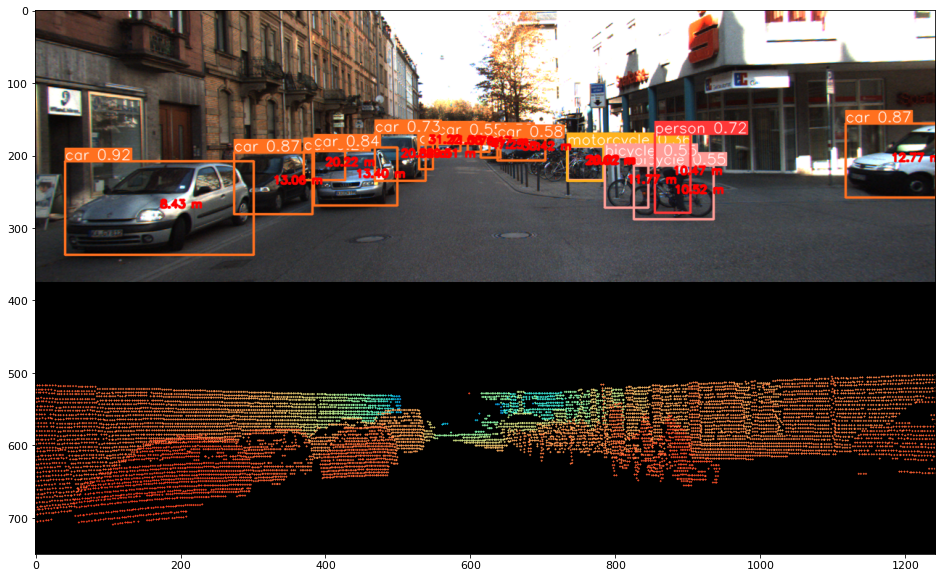

In [163]:
velo_image = np.zeros_like(left_image)
velo_image = draw_velo_on_image(velo_camera, velo_image)

# stack image with LiDAR point cloud
stacked = np.vstack((left_image, velo_image))

# display stacked iamge
plt.imshow(stacked);

In [22]:
# get object centers and rotate them to LiDAR space
object_centers = np.hstack((bboxes_out[:, 6:8], np.ones((len(bboxes_out), 2))))
object_centers 

array([[     273.22,      170.92,           1,           1],
       [     204.98,      1180.8,           1,           1],
       [     235.58,      329.19,           1,           1],
       [     231.49,      442.15,           1,           1],
       [     203.47,      503.98,           1,           1],
       [     227.42,      877.66,           1,           1],
       [     194.93,      671.39,           1,           1],
       [     195.92,      568.22,           1,           1],
       [     238.17,      814.91,           1,           1],
       [     252.16,      882.25,           1,           1],
       [     193.53,      628.75,           1,           1],
       [     212.79,      758.63,           1,           1],
       [     181.27,      612.88,           1,           1],
       [     212.79,      758.63,           1,           1],
       [     205.41,       539.6,           1,           1],
       [     214.59,      400.11,           1,           1],
       [     192.83,    

In [154]:
np.c_[object_centers[0, :]]

array([[     273.22],
       [     170.92],
       [          1],
       [          1]])

In [155]:
np.linalg.inv(T_cam_velo) @ np.c_[object_centers[0, :]]

array([[     5.8612],
       [    -273.08],
       [    -171.13],
       [          1]])

In [157]:
np.linalg.inv(P_left)

LinAlgError: ignored

## **Lets move on to extracting 3D point cloud objects**

First we need to run the RANSAC algorithm to remove the plane. But we will need to use the points the LiDAR frame of reference, so we need a way of contiunously relating the image point cloud with the True LiDAR point cloud

Read points directly from bin file and use RANSAC to remove the ground plane

In [30]:
velo_points = bin2h_velo(lidar_bin, remove_plane=True)

Now let's run K-means clustering in LiDAR space to get object clusters. First we will seed K-means with the centers of the detected objects

In [31]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=bboxes_out.shape[0])
# kmeans.init()
kmeans.fit(velo_points[:3, :].T)

KMeans(n_clusters=17)

In [46]:
velo_cam = velo2camera(velo_points, left_image, remove_outliers=True)

In [47]:
# draw clusters on new image
labels = kmeans.labels_
print(np.unique(labels))

pastel = cm.get_cmap('Pastel2')
get_pastel = lambda z : [255*val for val in pastel(int(z.round()))[:3]]

# unpack LiDAR points
u, v, z = velo_cam

# draw LiDAR point cloud on blank image
new_image = np.zeros_like(left_image)
for i in range(len(u)):
    cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
              get_pastel(labels[i]), -1);

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


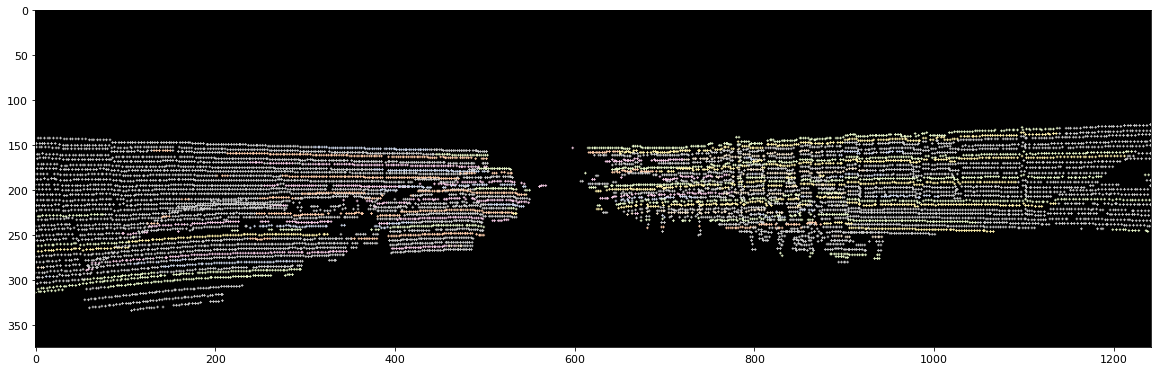

In [42]:
plt.imshow(new_image);

Compare with DBSCAN

In [280]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=2, min_samples=20)
dbscan.fit(velo_points[:3, :].T)

DBSCAN(eps=2, min_samples=20)

In [282]:
labels = dbscan.labels_

# get clusters in LiDAR space


In [126]:
# draw clusters on new image
labels = dbscan.labels_
print(np.unique(labels))

pastel = cm.get_cmap('Pastel2')
get_pastel = lambda z : [255*val for val in pastel(int(z.round()))[:3]]

# unpack LiDAR points
u, v, z = velo_camera

# draw LiDAR point cloud on blank image
new_image = np.zeros_like(left_image)
for i in range(len(u)):
    cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
              get_pastel(labels[i]), -1);

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33]


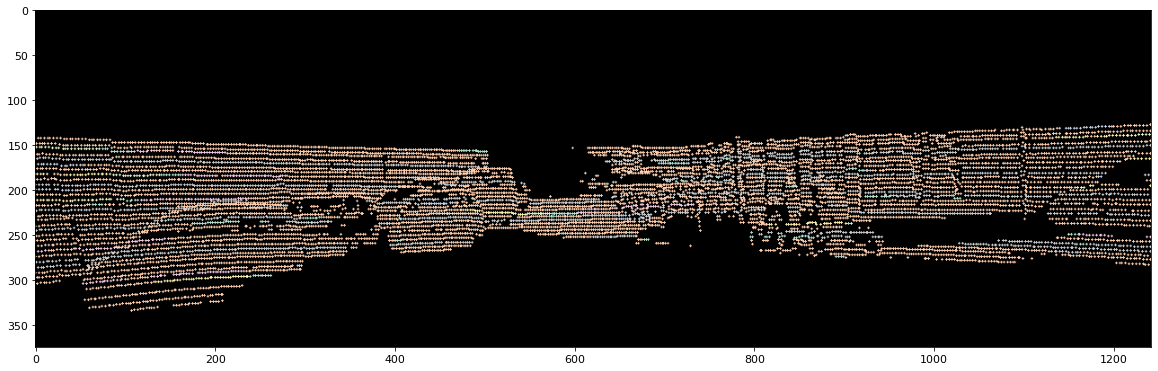

In [127]:
plt.imshow(new_image);

In [81]:
velo_points[:3, :]

array([[     76.942,      75.186,      73.536, ...,      14.955,      15.038,      15.174],
       [     11.739,      11.712,      11.691, ...,      -2.981,      -2.973,      -2.951],
       [      2.841,       2.782,       2.727, ...,      -6.995,      -7.032,      -7.092]], dtype=float32)

In [279]:
# draw clusters on new image
labels = dbscan.labels_
print(np.unique(labels))

pastel = cm.get_cmap('Pastel2')
get_pastel = lambda z : [255*val for val in pastel(int(z.round()))[:3]]

# unpack LiDAR points
x, y, z = velo_points[:3, :]

# draw LiDAR point cloud on blank image
new_image = np.zeros_like(left_image)
for i in range(len(z)):
    cv2.circle(new_image, (int(y[i] + 100), int(z[i]) + 100), 1, 
              get_pastel(labels[i]), -1);

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33]


IndexError: ignored

In [100]:
z.min()

-9.147

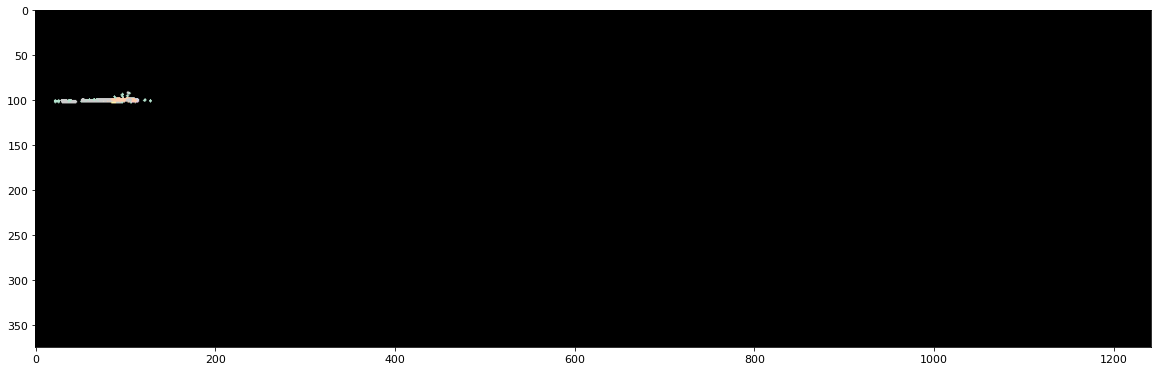

In [101]:
plt.imshow(new_image)

In [166]:
tmp = P_left @ R_left_rect @ T_cam_velo @ velo_points[:, labels == 0]
tmp[:2] /= tmp[2, :]
tmp.shape

(3, 37)

In [284]:
np.mean(velo_points[:, labels == 0], axis=1)

array([     59.812,      11.271,      1.1148,           1], dtype=float32)

In [283]:
tmp = P_left @ R_left_rect @ T_cam_velo @ np.mean(velo_points[:, labels == 0], axis=1)
tmp[:2] /= tmp[2]
tmp

array([     477.15,      170.56,      59.605])

In [305]:
arr = np.array([477.15, 170.56, 1]) 

In [308]:
np.linalg.inv(R_left) @ np.linalg.inv(K_left) @ np.c_[arr] - T_left[:3]

array([[   -0.12366],
       [ -0.0035372],
       [     1.0027]])

In [313]:
np.linalg.inv(R_left) @ np.c_[arr @ np.linalg.inv(K_left)] - T_left[:3]

array([[    0.72115],
       [    0.23603],
       [    -442.96]])

In [298]:
np.linalg.inv(R_left).shape

(3, 3)

In [286]:
T_left

array([[  -0.059849],
       [ 0.00035793],
       [ -0.0027459],
       [          1]])

In [287]:
K_left

array([[     721.54,           0,      609.56],
       [          0,      721.54,      172.85],
       [          0,           0,           1]])

In [144]:
np.unique(labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [145]:
np.sum(labels == 5)

245

In [169]:
new_points = velo2camera(velo_points[:, labels == 5], left_image)
new_points.shape

(3, 0)

In [171]:
new_points.shape[1]

0

In [149]:
# unpack LiDAR points
u, v, z = new_points

# draw LiDAR point cloud on blank image
new_image = np.zeros_like(left_image)
for i in range(len(z)):
    cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
              get_pastel(z[i]), -1);

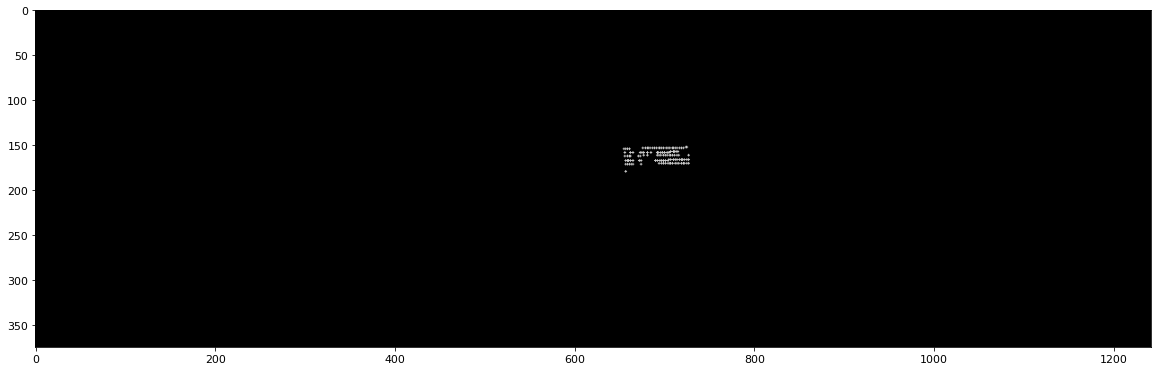

In [150]:
plt.imshow(new_image)

In [168]:
labels.shape

(74458,)

In [216]:
def image_clusters_from_velo(velo_points, labels, image):
    ''' Obtains clusters in image space from velo (LiDAR) points 
        Inputs:
            velo_points (4xN) Homogeneous LiDAR points
            labels (N,) cluster labels (clusters formed in LiDAR space)
            image - reference image for transformation from LiDAR to image space
        Outputs:
            clusters (list) list that contains each cluster label and cluster
        '''
    clusters = []
    for label in np.unique(labels):
        # convert from velo to camera 
        velo_cam = velo2camera(velo_points[:, labels == label], image)
        
        # append cluster label and cluster to clusters
        if velo_cam.shape[1] > 0:
            clusters.append([label, velo_cam])

    return clusters

In [268]:
def draw_clusters_on_image(image, clusters, draw_centroids=False):
    ''' draws the clusters on an image '''
    pastel = cm.get_cmap('Pastel2', lut=50)
    get_pastel = lambda z : [255*val for val in pastel(int(z.round()))[:3]]

    for cluster in clusters:
        label = cluster[0]
        for (u, v, z) in cluster[1].T:
            cv2.circle(image, (int(u), int(v)), 1, 
                       get_pastel(label), -1);

        if draw_centroids:
            centroid = np.mean(cluster[1], axis=1)
            cv2.circle(image, (int(centroid[0]), int(centroid[1])), 5, 
                       get_pastel(label), -1);

    return image


Read LiDAR data directly from bin file

In [277]:
velo_points = bin2h_velo(lidar_bin, remove_plane=True)

In [269]:
clusters = image_clusters_from_velo(velo_points, labels, left_image)

In [270]:
new_image = np.zeros_like(left_image)
new_image = draw_clusters_on_image(new_image, clusters, draw_centroids=True)

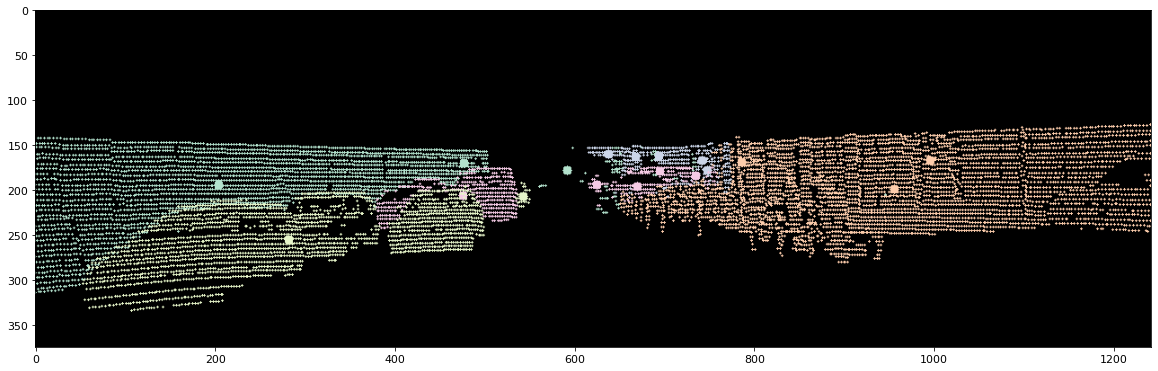

In [271]:
plt.imshow(new_image)

In [190]:
tmp = 
tmp[0]

-1

In [215]:
clusters[15][1].min(axis=1)

array([     12.946,      3.8767,      47.189])

Convert camera reference to real world units
https://stackoverflow.com/questions/47054848/converting-pixel-width-to-real-world-width-in-millimeters-using-camera-calibrati

Camera calibration info
https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-for-camera-calibration-in-computer-vision/

Sensor size of cameras used
https://www.alliedvision.com/en/camera-selector/detail/manta/g-146/

compute camera sensor width: http://www.lightcrafttech.com/support/doc/lens-interface/camera-sensor/

TO get the width of the sensor in pixels we divide the physical width of the sensor (in meters) by the nuber of pixels along the horizonal axis

calculate pixel pitch: https://myelo.elotouch.com/support/s/article/How-to-Calculate-Pixel-Pitch

https://www.fdxlabs.com/calculate-x-y-z-real-world-coordinates-from-a-single-camera-using-opencv/

In [275]:
focal_length = K_left[0, 0]

In [ ]:
sensor_width_pix = 1382

In [ ]:
!pip install open3d

In [250]:
masked_velo_points[:3, :]

array([[     76.942,      75.186,      73.536, ...,      14.955,      15.038,      15.174],
       [     11.739,      11.712,      11.691, ...,      -2.981,      -2.973,      -2.951],
       [      2.841,       2.782,       2.727, ...,      -6.995,      -7.032,      -7.092]], dtype=float32)

In [251]:
import open3d as o3d

pcd = o3d.geometry.PointCloud()

xyz = np.asarray(masked_velo_points[:3, :].T)
pcd.points = o3d.utility.Vector3dVector(xyz)

In [ ]:
# cluster point cloud
with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    labels = np.array(pcd.cluster_dbscan(eps=20, 
                                         min_points=8, 
                                         print_progress=True))

In [1]:
np.unique(labels)

NameError: ignored

In [174]:
import copy

pcd2 = copy.deepcopy(pcd)

max_label = labels.max() + 1
colors = plt.get_cmap('tab20')(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0
pcd2.colors = o3d.utility.Vector3dVector(colors[:, :3])

In [175]:
pcd2

PointCloud with 10310 points.

In [176]:
def get_clusters_from_labels(pcd, labels, include_outliers=True):
    ''' Obtains a list of individual cluster point clouds and paints them 
        unique colors. Assumes that the pcd object has a uniform color.
        Inputs:
            pcd - open3d PointCloud object
            labels - (Nx1 array) labels for each point in the cluster
            include_outliers - (_Bool) determines whether outlaiers should be 
                               included in the output list
        Outputs:
            unique_labels (list) Contains all labels for each cluster
            clusters (list) Contains PointCloud objects for each color
        '''
    # get colors 
    max_label = labels.max()
    colors = plt.get_cmap('tab20')
    colors = colors(labels/(max_label if max_label > 0 else 1))
    colors[labels < 0] = 0
    
    unique_labels = np.sort(np.unique(labels))
    
    # remove -1 (unclustered label) to remove outliers if desired
    if not include_outliers:
        unique_labels = unique_labels[unique_labels != -1]

    # store cluster point clouds in a list
    clusters = []
    
    # iterate through each unique label
    for label in unique_labels:
        # get index of points and colors
        cluster_idx = np.where(label == labels)[0]
        
        # get cluster color
        color = colors[cluster_idx, :3]
        
        # get cluster points
        cluster = pcd.select_by_index(cluster_idx)
        
        # paint cluster
        cluster.colors = o3d.utility.Vector3dVector(color)
        
        # append to list
        clusters.append(cluster)
    
    return unique_labels, clusters

consider the first object with bbox_out of:
[     41.952,      208.31,      301.98,      337.09,       0.923,           2,      273.22,      170.92,      8.4331]


In [243]:
u_locs = (masked_velo_camera[0, :] >= 40) & (masked_velo_camera[0, :] <= 310)
v_locs = (masked_velo_camera[1, :] >= 200) & (masked_velo_camera[1, :] <= 340)

In [244]:
obj1_velo_camera = masked_velo_camera[:, u_locs & v_locs]
obj1_velo_camera.shape

(3, 1960)

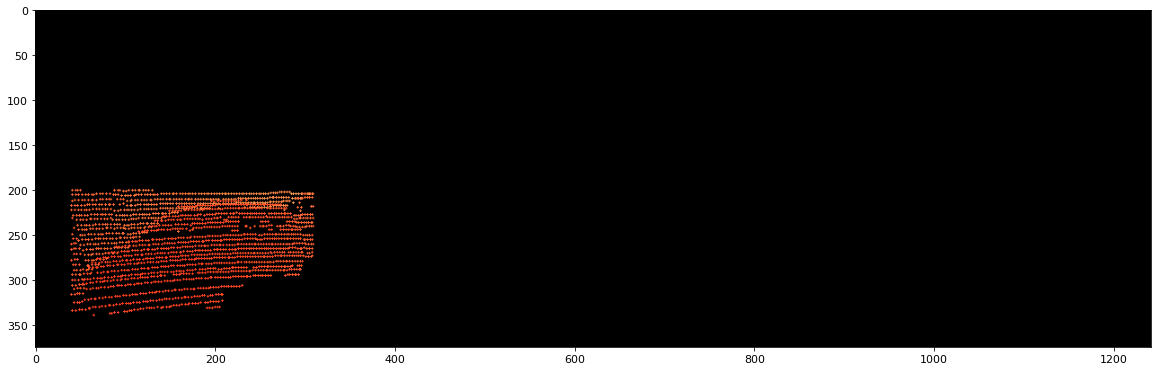

In [245]:
new_image = np.zeros_like(left_image)
new_image = draw_velo_on_image(obj1_velo_camera, new_image)

plt.imshow(new_image);

In [339]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=5, min_samples=5)

model.fit(obj1_velo_camera.T)

DBSCAN(eps=5)

In [340]:
np.unique(model.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])

In [201]:
velo_camera.T.max(axis=0)

array([     1241.9,      374.99,      78.473])

In [205]:
np.vstack((bboxes_out[:, 7], bboxes_out[:, 6], bboxes_out[:, 8])).T

array([[     170.92,      273.22,      8.4331],
       [     1180.8,      204.98,      12.768],
       [     329.19,      235.58,      13.057],
       [     442.15,      231.49,      13.397],
       [     503.98,      203.47,      20.855],
       [     877.66,      227.42,      10.472],
       [     671.39,      194.93,      33.416],
       [     568.22,      195.92,      71.531],
       [     814.91,      238.17,      11.769],
       [     882.25,      252.16,      10.521],
       [     628.75,      193.53,      47.248],
       [     758.63,      212.79,       20.02],
       [     612.88,      181.27,      76.168],
       [     758.63,      212.79,       20.02],
       [      539.6,      205.41,      29.514],
       [     400.11,      214.59,      20.223],
       [     541.91,      192.83,      31.222]])

In [206]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=17, init=np.vstack((bboxes_out[:, 7], bboxes_out[:, 6], bboxes_out[:, 8])).T)
# model.init(bboxes_out[:, 6:8])
model.fit(velo_camera.T)

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


KMeans(init=array([[     170.92,      273.22,      8.4331],
       [     1180.8,      204.98,      12.768],
       [     329.19,      235.58,      13.057],
       [     442.15,      231.49,      13.397],
       [     503.98,      203.47,      20.855],
       [     877.66,      227.42,      10.472],
       [     671.39,      194.93,      33.416],
       [     568.22,      195.92,      71.531],
       [     814.91,      238.17,      11.769],
       [     882.25,      252.16,      10.521],
       [     628.75,      193.53,      47.248],
       [     758.63,      212.79,       20.02],
       [     612.88,      181.27,      76.168],
       [     758.63,      212.79,       20.02],
       [      539.6,      205.41,      29.514],
       [     400.11,      214.59,      20.223],
       [     541.91,      192.83,      31.222]]),
       n_clusters=17)

In [207]:
np.unique(model.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16], dtype=int32)

In [225]:
# p#astel = cm.get_cmap('hsv')
# get_pastel = lambda z : [255*val for val in pastel(int(z.round()))[:3]]

# unpack LiDAR points
u, v, z = velo_camera # obj1_velo_camera
labels = model.labels_

# draw LiDAR point cloud on blank image
new_image = np.zeros_like(left_image)
for i in range(len(u)):
    if labels[i] == 15:
        cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
                  get_pastel(labels[i]), -1);

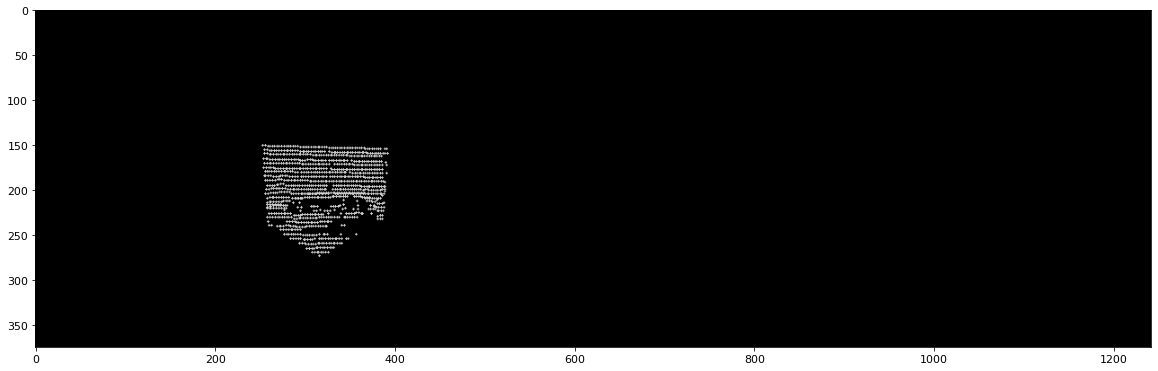

In [226]:
plt.imshow(new_image);

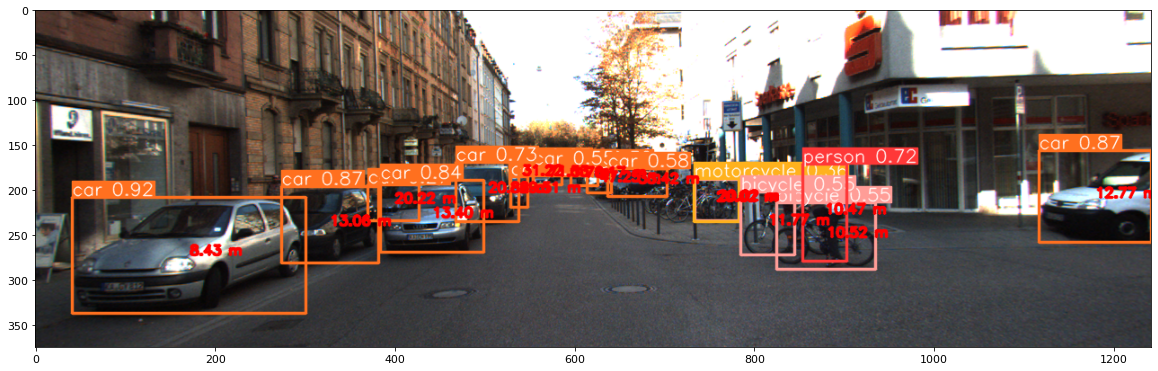

In [214]:
plt.imshow(left_image)

In [148]:
obj1_velo_camera[1, :].shape

(2217,)

In [149]:
pastel = cm.get_cmap('hsv')
get_pastel = lambda z : [255*val for val in pastel(int(z.round()))[:3]]

# unpack LiDAR points
u, v, z = obj1_velo_camera
labels = model.labels_

# draw LiDAR point cloud on blank image
new_image = np.zeros_like(left_image)
for i in range(len(u)):
    cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
               get_pastel(labels[i]), -1);

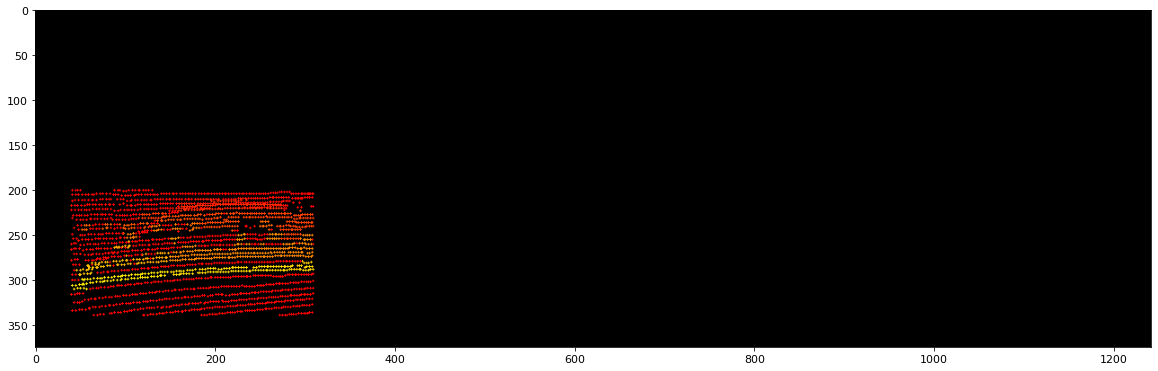

In [150]:
plt.imshow(new_image);

## Now we can try to use PCA to get principle axes of the object of interest

## **Now make a full pipeline**
This pipeline will input a stereo pair along with a LiDAR point cloud. It will compute stereo depth and log error info

## **Now let's run the depth check on another sample of KITTI data!**

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip

--2022-08-28 18:56:13--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_drive_0047/2011_10_03_drive_0047_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.168.92
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.168.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103291675 (2.9G) [application/zip]
Saving to: ‘2011_10_03_drive_0047_sync.zip’

2011_10_03_drive_00 100%[===================>]   2.89G  10.8MB/s    in 4m 36s  

2022-08-28 19:00:50 (10.7 MB/s) - ‘2011_10_03_drive_0047_sync.zip’ saved [3103291675/3103291675]



In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip

--2022-08-28 19:00:51--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_10_03_calib.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.72.151
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.72.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4075 (4.0K) [application/zip]
Saving to: ‘2011_10_03_calib.zip’

2011_10_03_calib.zi 100%[===================>]   3.98K  --.-KB/s    in 0s      

2022-08-28 19:00:52 (58.0 MB/s) - ‘2011_10_03_calib.zip’ saved [4075/4075]



In [ ]:
!jar xf 2011_10_03_drive_0047_sync.zip

In [ ]:
!jar xf 2011_10_03_calib.zip

### Get the Calibration data

In [ ]:
with open('2011_10_03/calib_cam_to_cam.txt','r') as f:
    calib = f.readlines()

# get projection matrices
P_left = np.array([float(x) for x in calib[25].strip().split(' ')[1:]]).reshape((3,4))
P_right = np.array([float(x) for x in calib[33].strip().split(' ')[1:]]).reshape((3,4))

# get rectified rotation matrices
R_left_rect = np.array([float(x) for x in calib[24].strip().split(' ')[1:]]).reshape((3, 3,))
R_right_rect = np.array([float(x) for x in calib[32].strip().split(' ')[1:]]).reshape((3, 3,))

R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0], axis=0)
R_left_rect = np.insert(R_left_rect, 3, values=[0,0,0,1], axis=1)

# decompose projection matrices
K_left, R_left, T_left = decompose_projection_matrix(P_left)
K_right, R_right, T_right = decompose_projection_matrix(P_right)

In [ ]:
with open(r'2011_10_03/calib_velo_to_cam.txt', 'r') as f:
    calib = f.readlines()

R_cam_velo = np.array([float(x) for x in calib[1].strip().split(' ')[1:]]).reshape((3, 3))
t_cam_velo = np.array([float(x) for x in calib[2].strip().split(' ')[1:]])[:, None]

T_cam_velo = np.vstack((np.hstack((R_cam_velo, t_cam_velo)),
                        np.array([0, 0, 0, 1])))

In [ ]:
DATA_PATH = r'2011_10_03/2011_10_03_drive_0047_sync'

left_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_02/data/*.png')))
right_image_paths = sorted(glob(os.path.join(DATA_PATH, 'image_03/data/*.png')))

# get LiDAR data
bin_paths = sorted(glob(os.path.join(DATA_PATH, 'velodyne_points/data/*.bin')))

print(f"Number of left images: {len(left_image_paths)}")
print(f"Number of right images: {len(right_image_paths)}")
print(f"Number of LiDAR point clouds: {len(bin_paths)}")

Number of left images: 837
Number of right images: 837
Number of LiDAR point clouds: 837


## **Now let's make a video**

In [ ]:
error_metrics = []
result_video = []

for idx in range(len(left_image_paths)):
    left_image = cv2.cvtColor(cv2.imread(left_image_paths[idx]), cv2.COLOR_BGR2RGB)
    right_image = cv2.cvtColor(cv2.imread(right_image_paths[idx]), cv2.COLOR_BGR2RGB)
    lidar_bin = bin_paths[idx]

    left_image, velo_camera, errors, centers = stereo_depth_pipeline(
                                                                left_image, 
                                                                right_image, 
                                                                lidar_bin, 
                                                                draw_boxes=True, 
                                                                method='median')
    
    # draw LiDAR point cloud on new blank image
    u, v, z = velo_camera
    new_image = np.zeros_like(left_image, dtype=np.uint8)
    for i in range(len(u)):
        cv2.circle(new_image, (int(u[i]), int(v[i])), 1, 
                  get_color(z[i]), -1);
    
    # stack frames
    stacked = np.vstack((left_image, new_image))

    # add to result video
    result_video.append(stacked)

    # ensure that errors were recorded
    if len(errors) > 0:
        error_metrics.append(errors)

# get width and height for video frames
h, w, _ = stacked.shape

out = cv2.VideoWriter('boxed_pointcloud_stack_2011_10_03.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, (w,h))

# or use mp4
# out = cv2.VideoWriter('boxed_pointcloud_stack_2011_10_03.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, (w,h))
 
for i in range(len(result_video)):
    out.write(cv2.cvtColor(result_video[i], cv2.COLOR_BGR2RGB))
out.release()

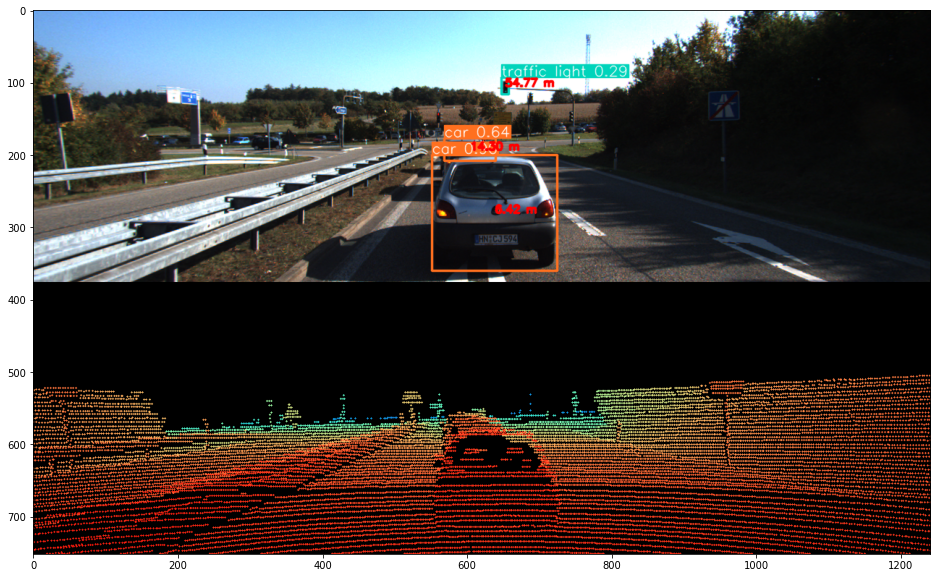

In [ ]:
plt.imshow(stacked);